##  Age-structured SIR model for India with social distancing

**for an idealised best-case**. We assume that lockdown **instantaneously** and **completely** removes all social contacts from the spheres of workplace, schools, and others. The contact matrix, then, is time-dependent, whose form we take to be
$$
C_{ij}(t) = C_{ij} + u(t)(C^W_{ij} + C^S_{ij} + C^O_{ij}) 
$$
where $u(t)$ is a control function given by
$$
u(t) = \frac{1}{2}\left[\tanh\left(\frac{t-t_{\text{on}}}{t_w}\right)-\tanh\left(\frac{t-t_{\text{off}}}{t_w}\right)\right]
$$
This function has three parameters: the time at which the social distancing is implemented, $t_{\text on}$, the time at which it is lifted $t_{\text {off}}$ and the **lag** between implementation and compliance $t_w$. In the best-case scenario, we assume that this lag is less than day, or in other words, the lockdown acts  **instantaneously**. The function $u(t)$ is one in  window $t_{\text on} \leq t \leq t_{\text{off}}$ and zero outside. We can multiply this by a scale factor $0\leq \epsilon \leq 1$ as a measure of the efficacy of the social distancing. The value $\epsilon =1$ reflects complete compliance; the value $\epsilon=0$ reflects zero compliance. In the best-scenario, we assume  $\epsilon =1$ so there is no scale factor in the control function. 

We now numerically integrate as before, imposing controls of 21 days duration and lifting it afterwards. We also explore various other scenarios, with several periods of lockdown separated by periods of relaxation. The goal is to reduce the number of infectives. In the language of optimal control, our cost function is the number of infectives. We find that the 21 day lockdown will not reduce the number of infectives to a point where explicit contact tracing will be feasible. We take the number 10 to represent a point where social contact tracing may be feasible. This is dependent on region and the effectiveness with which such measures can be implemented. We find a longer lockdowns are needed to bring the number of infectives down to that level. 

------------------------------------------------------------------------------------------------------------------------------

#### After creating/cloning a new environment, with all the dependencies, either using conda or from ArcGIS Pro. 
#### (As per the instructions in the Readme.md)
#### Proceed with this notebook.

------------------------------------------------------------------------------------------------------------------------------

**Model C: Multiple lockdown**

---

* Checking Env.

In [ ]:
#forked from Rajesh Singh's work, related to Pyross Lib.
import sys
sys.executable

---

* Importing all req. libraries.

In [1]:
%matplotlib inline                  
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt     # optional for notebook visualization.

# imports for AGOL publishing
from arcgis.gis import GIS

---

* Loading & defining model parameters:

In [2]:
M=16  # number of age groups

# load age structure data
my_data = np.genfromtxt('data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

In [3]:
# contact matrices
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_home_1.xlsx', sheet_name='India',index_col=None)
CH = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_work_1.xlsx', sheet_name='India',index_col=None)
CW = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_school_1.xlsx', sheet_name='India',index_col=None)
CS = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_other_locations_1.xlsx', sheet_name='India',index_col=None)
CO = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_all_locations_1.xlsx', sheet_name='India',index_col=None)
CA = np.array(my_data)

# matrix of total contacts
C=CH+CW+CS+CO

In [4]:
beta  = 0.01646692       # infection rate 
gIa   = 1./7             # recovery rate of asymptomatic infectives 
gIs   = 1./7             # recovery rate of symptomatic infectives 
alpha = 0.               # fraction of asymptomatic infectives 
fsa   = 1                # the self-isolation parameter   
    
    
# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=3;  Is_0[2:6]=1

Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))

for i in range(M):
    for j in range(M):
        L0[i,j]=C[i,j]*Ni[i]/Ni[j]

L[0:M, 0:M]     =    alpha*beta/gIs*L0
L[0:M, M:2*M]   = fsa*alpha*beta/gIs*L0
L[M:2*M, 0:M]   =    ((1-alpha)*beta/gIs)*L0
L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gIs)*L0


r0 = np.max(np.linalg.eigvals(L))
print("The basic reproductive ratio for these parameters is", r0)

---

* Running the Model & Creating Model file

In [5]:
# duration of simulation and data file
# tf - no of days starting from 23 feb 2020 for india, Nf - no of prediction data points. 

Tf=200;  Nf=200;

# the contact structure is independent of time 

# the contact matrix is time-dependent
def contactMatrix(t):
    if t<31:
        xx = C
    elif 31<=t<52:
        xx = CH
    elif 52<=t<57:
        xx = C
    elif 57<=t<85:
        xx = CH
    elif 85<=t<90:
        xx = C
    else:
        xx = CH
    return xx

# Input data, inside model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.models.SIR(parameters, M, Ni)


# run model
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

---

* Getting the Results ready for ArcGIS online ___>>>___ Then to Dashboard.

In [ ]:
# Loading predictions

IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
        
# Loading actual data, kindly update the data by subtracting recovered & no of deaths, so far.

my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=4)
day, cases = my_data[:,0], my_data[:,2]

In [ ]:
# Making the results, ArcGIS Online compatible

main_table = pd.DataFrame(data=IC, columns=["no of predicted cases"])
main_table['date'] = pd.date_range(start='2/23/2020', periods=len(main_table), freq='D')
main_table['no of predicted cases'] = main_table['no of predicted cases'].apply(np.int64)


true_no_of_cases= pd.DataFrame(data=cases, columns=["no of actual cases"])

final_table = pd.concat([main_table, true_no_of_cases], axis=1, sort=False)
col = final_table.columns.tolist()
col = col[-1:] + col[:-1]; col = col[-1:] + col[:-1]
final_table = final_table[col]  

final_table.to_excel (r'_Model_C_.xlsx', index = False, header=True)

final_table.head()

---

* for different colour visualization on Dashboard, within the predicted cases for lockdown.

In [ ]:
true_no_of_cases= pd.DataFrame(data=cases, columns=["no of actual cases"])

main_table_all_data1 = pd.DataFrame(data=IC, columns=["pre-lockdown 1: predicted cases"])
main_table_all_data1['pre-lockdown 1: predicted cases'] = main_table_all_data1['pre-lockdown 1: predicted cases'].apply(np.int64)
main_table_all_data1[31:]=None

main_table_all_data1['date'] = pd.date_range(start='2/23/2020', periods=len(main_table_all_data1), freq='D')

main_table_lockdown1 = pd.DataFrame(data=IC, columns=["lockdown 1: predicted cases"])
main_table_lockdown1['lockdown 1: predicted cases'] = main_table_lockdown1['lockdown 1: predicted cases'].apply(np.int64)
main_table_lockdown1[0:31]=None
main_table_lockdown1[52:]=None

main_table_all_data2 = pd.DataFrame(data=IC, columns=["post-lockdown 1: predicted cases"])
main_table_all_data2['post-lockdown 1: predicted cases'] = main_table_all_data2['post-lockdown 1: predicted cases'].apply(np.int64)
main_table_all_data2[0:52]=None
main_table_all_data2[57:]=None

main_table_lockdown2 = pd.DataFrame(data=IC, columns=["lockdown 2: predicted cases"])
main_table_lockdown2['lockdown 2: predicted cases'] = main_table_lockdown2['lockdown 2: predicted cases'].apply(np.int64)
main_table_lockdown2[0:57]=None
main_table_lockdown2[85:]=None

main_table_all_data3 = pd.DataFrame(data=IC, columns=["post-lockdown 2: predicted cases"])
main_table_all_data3['post-lockdown 2: predicted cases'] = main_table_all_data3['post-lockdown 2: predicted cases'].apply(np.int64)
main_table_all_data3[0:85]=None
main_table_all_data3[90:]=None

main_table_lockdown3 = pd.DataFrame(data=IC, columns=["lockdown 3: predicted cases"])
main_table_lockdown3['lockdown 3: predicted cases'] = main_table_lockdown3['lockdown 3: predicted cases'].apply(np.int64)
main_table_lockdown3[0:90]=None
main_table_lockdown3[108:]=None


main_table_all_data4 = pd.DataFrame(data=IC, columns=["post-lockdown 3: predicted cases"])
main_table_all_data4['post-lockdown 3: predicted cases'] = main_table_all_data4['post-lockdown 3: predicted cases'].apply(np.int64)
main_table_all_data4[0:108]=None




final_table = pd.concat([true_no_of_cases, main_table_lockdown1, main_table_all_data1, main_table_all_data2, main_table_lockdown2, main_table_all_data3, main_table_lockdown3, main_table_all_data4], axis=1, sort=False)


col = final_table.columns.tolist()
col = col[-1:] + col[:-1]; col = col[-1:] + col[:-1]
col = col[-1:] + col[:-1]; col = col[-1:] + col[:-1]
col = col[-1:] + col[:-1]; col = col[-1:] + col[:-1]
final_table = final_table[col]  

final_table.to_excel (r'_Model_C_.xlsx', index = False, header=True)

final_table.head()


---

* Publish the results on AGOL

In [ ]:
# provide your AGOL account details below:
# for more help go to https://developers.arcgis.com/python/sample-notebooks/publishing-sd-shapefiles-and-csv/

username = "username"
password = "password"
gis = GIS("link", username, password)


table_file = '_Model_C_.xlsx'


online_table= gis.content.add({'type': 'Microsoft Excel'}, table_file)


folder_name='covid_dsb_test'

#skip the line below, if you already have created a folder for this work. 
folder = gis.content.create_folder(folder_name)

# Move the table
online_table.move(folder)

#publishing the table
model_initial = online_table.publish(overwrite=True)
model_initial.move(folder)

#add the layer to your Dashboard.

---

* Optional Notebook visualization 

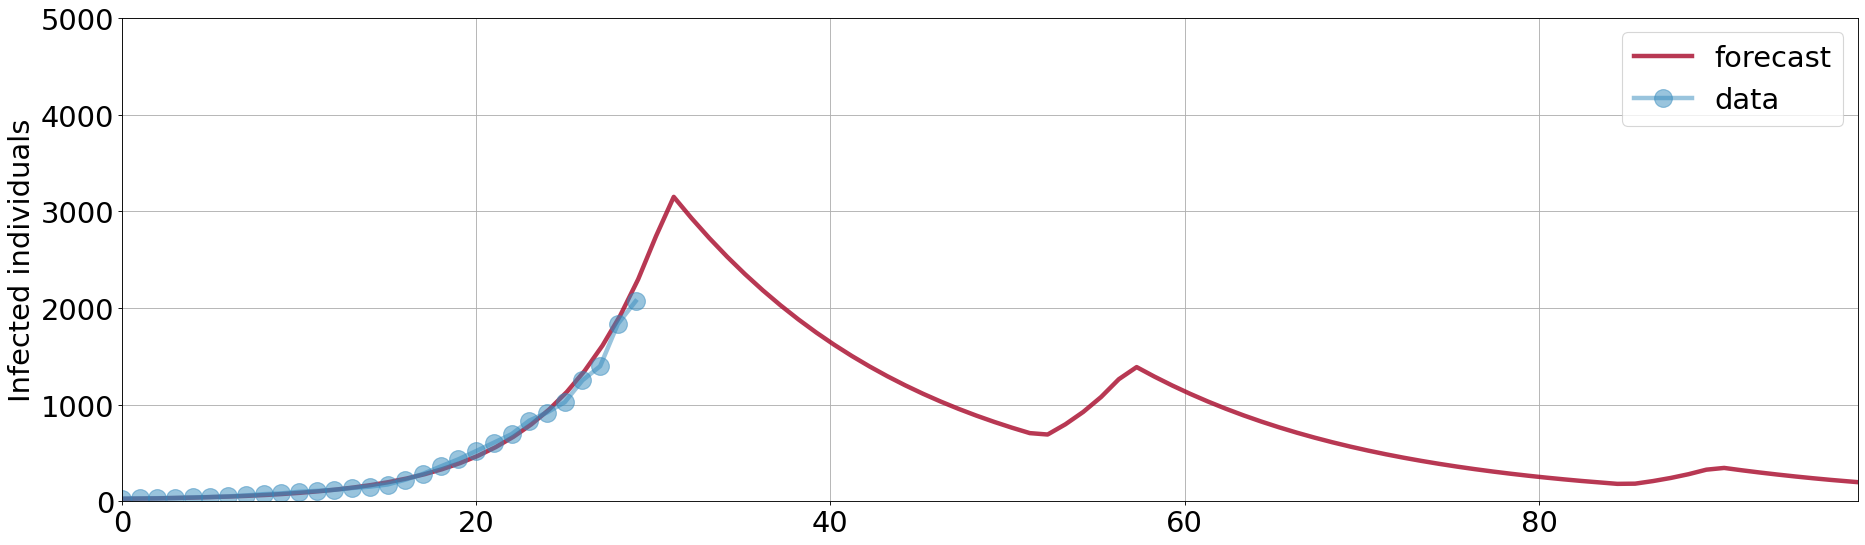

In [7]:
IC  = np.zeros((Nf))
SC  = np.zeros((Nf))
t = data['t']
for i in range(M):
        IC += data['X'][:,2*M+i] 
        SC += data['X'][:,0*M+i]

    
  
fig =plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})


my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=4)
day, cases = my_data[:,0], my_data[:,2]  

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)





plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.xlim(0, 98); plt.ylim(0, 5000);


---

---

In [ ]:
---